In [1]:
# 1. Načítanie knižníc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2. Načítanie oboch CSV
df = pd.read_csv("../.scratch/all_predictions_goals.csv")

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Funkcia na výpočet derivácie cez klzavé okno
def moving_average_derivative(values, window_size=5):
    return np.diff(np.convolve(values, np.ones(window_size)/window_size, mode='valid'))

# Funkcia na výpočet druhej derivácie
def second_derivative(values):
    first_derivative = np.diff(values)
    return np.diff(first_derivative)

# Funkcia na výpočet druhej derivácie pohyblivého priemeru
def second_moving_average_derivative(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return second_derivative(moving_avg)

# Funkcia na výpočet max hodnoty pohyblivého priemeru
def max_moving_average(values, window_size=5):
    moving_avg = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return np.max(np.abs(moving_avg))

# Výpočet metriky pre každú šancu
def compute_metrics(df):
    metrics = []

    for chance_id, group in df.groupby("chance_id"):
        values = group["value"].values

        max_abs_value = np.max(np.abs(values))
        min_max_diff = np.abs(np.max(values) - np.min(values))
        top_10_avg = np.mean(np.sort(np.abs(values))[-10:])
        max_derivative = np.max(np.abs(np.diff(values)))
        max_second_derivative = np.max(np.abs(second_derivative(values)))
        max_moving_avg_derivative = np.max(np.abs(moving_average_derivative(values)))
        max_second_moving_avg_derivative = np.max(np.abs(second_moving_average_derivative(values)))
        max_moving_value = np.abs(max_moving_average(values))

        metrics.append({
            "chance_id": chance_id,
            "max_abs_value": max_abs_value,
            "top_10_avg": top_10_avg,
            "min_max_diff": min_max_diff,
            "max_derivative": max_derivative,
            "max_second_derivative": max_second_derivative,
            "max_moving_derivative": max_moving_avg_derivative,
            "max_second_moving_derivative": max_second_moving_avg_derivative,
            "max_moving_value": max_moving_value,
            "true_label": group["chance"].iloc[0]
        })

    return pd.DataFrame(metrics)


def find_precision_recall_intersection(thresholds, precision, recall):
    for i in range(len(thresholds) - 1):
        p1, p2 = precision[i], precision[i + 1]
        r1, r2 = recall[i], recall[i + 1]

        if (p1 - r1) * (p2 - r2) < 0:
            t1, t2 = thresholds[i], thresholds[i + 1]
            dp, dr, dt = p2 - p1, r2 - r1, t2 - t1
            alpha = (r1 - p1) / ((dp - dr) + 1e-8)
            t_cross = t1 + alpha * dt
            precision_interp = p1 + alpha * dp
            return t_cross, precision_interp

    i = np.argmin(np.abs(np.array(precision) - np.array(recall)))
    return thresholds[i], (precision[i] + recall[i]) / 2


def evaluate_thresholds(df_metrics, column, thresholds=np.linspace(-1, 1, 1000)):
    precision, recall = [], []

    for t in thresholds:
        preds = df_metrics[column] > t
        tp = ((preds == True) & (df_metrics["true_label"] == "chance")).sum()
        fp = ((preds == True) & (df_metrics["true_label"] == "no_chance")).sum()
        fn = ((preds == False) & (df_metrics["true_label"] == "chance")).sum()

        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)

        precision.append(prec)
        recall.append(rec)

    t_cross, score = find_precision_recall_intersection(thresholds, precision, recall)

    print(f"{column}:")
    print(f"  Precision ≈ Recall ≈ {score:.3f} at threshold ≈ {t_cross:.3f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision, label="Precision", color="#1f77b4")
    plt.plot(thresholds, recall, label="Recall", color="#ff7f0e")
    plt.axvline(t_cross, linestyle='--', color='gray', label=f"Threshold ≈ {t_cross:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision / Recall pre {column}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


max_abs_value:
  Precision ≈ Recall ≈ 0.450 at threshold ≈ 0.277


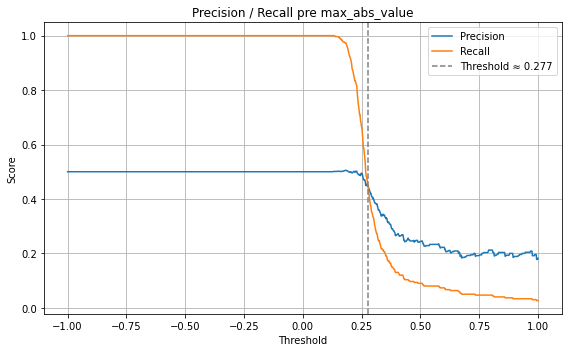

top_10_avg:
  Precision ≈ Recall ≈ 0.462 at threshold ≈ 0.245


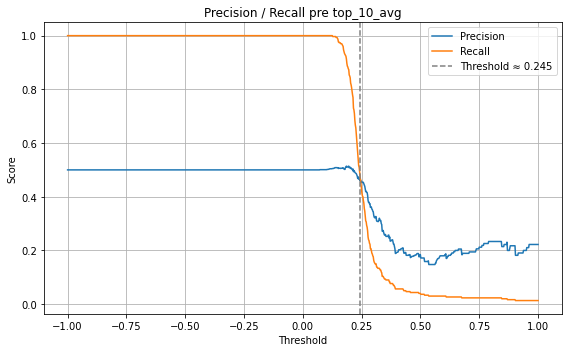

min_max_diff:
  Precision ≈ Recall ≈ 0.463 at threshold ≈ 0.319


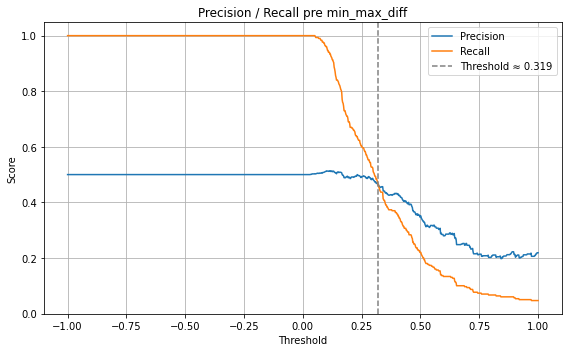

max_derivative:
  Precision ≈ Recall ≈ 0.420 at threshold ≈ 0.211


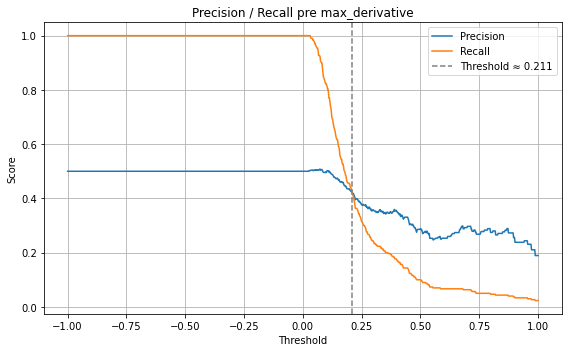

max_second_derivative:
  Precision ≈ Recall ≈ 0.427 at threshold ≈ 0.334


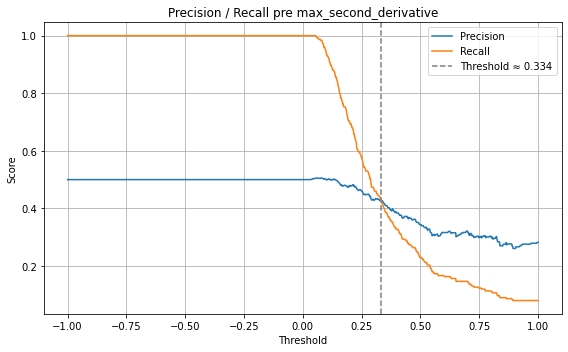

max_moving_value:
  Precision ≈ Recall ≈ 0.440 at threshold ≈ 0.235


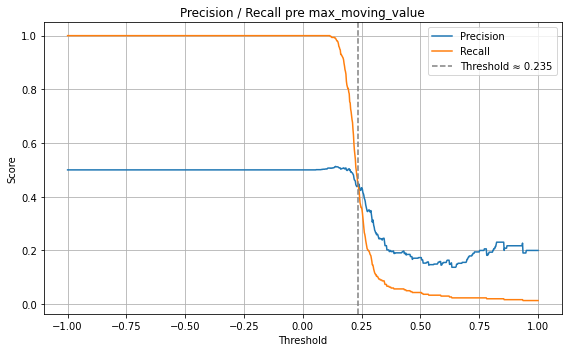

max_moving_derivative:
  Precision ≈ Recall ≈ 0.466 at threshold ≈ 0.047


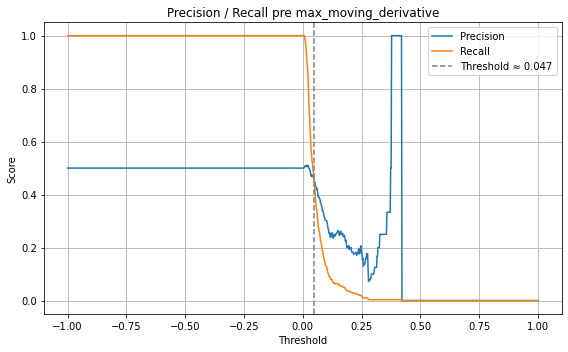

max_second_moving_derivative:
  Precision ≈ Recall ≈ 0.422 at threshold ≈ 0.046


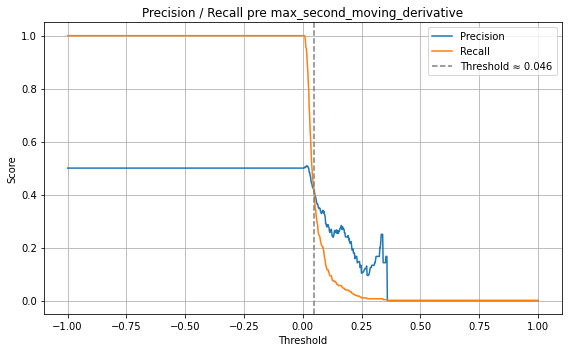

In [12]:

# 2. Vypočítaj metriky
df_metrics = compute_metrics(df)

# 3. Zoznam stĺpcov, ktoré chceš analyzovať
columns = [
    "max_abs_value",
    "top_10_avg",
    "min_max_diff",
    "max_derivative",
    "max_second_derivative",
    "max_moving_value",
    "max_moving_derivative",
    "max_second_moving_derivative"
]

# 4. Vyhodnoť každý stĺpec
for column in columns:
    evaluate_thresholds(df_metrics, column)

In [6]:
df_metrics

,chance_id,max_abs_value,top_10_avg,min_max_diff,max_derivative,max_second_derivative,max_moving_derivative,max_second_moving_derivative,max_moving_value,true_label
0,0,0.25516,0.203080,0.37931,0.21077,0.33608,0.075862,0.058526,0.201510,chance
1,1,0.28863,0.265521,0.09835,0.06638,0.09732,0.011548,0.018718,0.259382,chance
2,2,0.28104,0.264467,0.14069,0.06612,0.09347,0.019898,0.017262,0.271350,chance
3,3,0.26820,0.242883,0.40877,0.23222,0.25202,0.053692,0.045270,0.244572,chance
4,4,0.26662,0.235176,0.22765,0.13924,0.22300,0.027966,0.034966,0.238382,chance
...,...,...,...,...,...,...,...,...,...,...
595,595,1.01499,0.470955,1.35945,0.71855,1.30312,0.239216,0.203452,0.572560,no_chance
596,596,0.27114,0.180644,0.43522,0.19912,0.37741,0.059200,0.056424,0.171342,no_chance
597,597,1.29783,0.577681,1.60143,0.94109,1.57068,0.287038,0.215194,0.791162,no_chance
598,598,0.21642,0.185126,0.29325,0.24974,0.31181,0.036242,0.041628,0.162632,no_chance


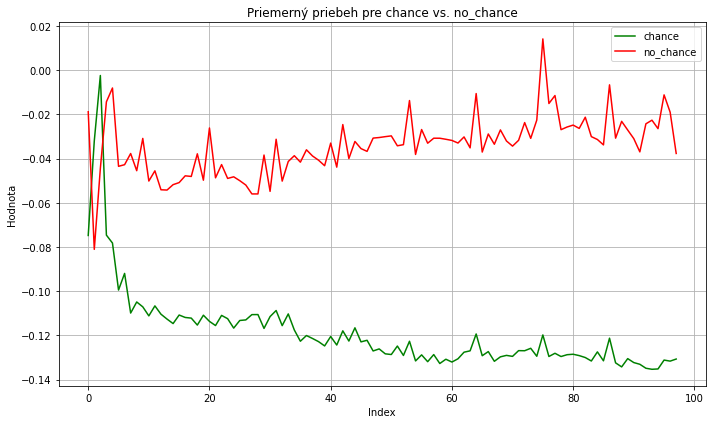

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_by_class(df):
    grouped = df.groupby("chance_id")
    
    # Predpokladáme rovnakú dĺžku sekvencií ako má prvý záznam
    first_length = len(next(iter(grouped))[1]["value"])

    sequences = []
    labels = []

    for chance_id, group in grouped:
        values = group["value"].values
        if len(values) == first_length:
            sequences.append(values)
            labels.append(group["chance"].iloc[0])  # string: "chance" alebo "no_chance"

    sequences = np.array(sequences)
    labels = np.array(labels)

    chance_seqs = sequences[labels == "chance"]
    no_chance_seqs = sequences[labels == "no_chance"]

    if chance_seqs.shape[0] == 0:
        raise ValueError("Žiadne sekvencie s labelom 'chance'")
    if no_chance_seqs.shape[0] == 0:
        raise ValueError("Žiadne sekvencie s labelom 'no_chance'")

    chance_avg = np.mean(chance_seqs, axis=0)
    no_chance_avg = np.mean(no_chance_seqs, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(chance_avg, label="chance", color='green')
    plt.plot(no_chance_avg, label="no_chance", color='red')
    plt.title("Priemerný priebeh pre chance vs. no_chance")
    plt.xlabel("Index")
    plt.ylabel("Hodnota")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Volaj takto:
plot_average_by_class(df)
